# Temperature Data Extraction Tutorial

In [1]:
from matplotlib import pyplot as plt
import matplotlib 
%matplotlib inline
import pandas as pd
import gdal
import os
import datetime
from datetime import timedelta
import numpy as np
import fiona
import shapely
from shapely import geometry
from os.path import dirname
import glob
import sys
import pickle
from functools import partial
import geopandas as gp
parent_dir = dirname(dirname(os.getcwd()))
sys.path.append(os.path.join(parent_dir,'StreamflowTempModel','lib'))
rew_config = pickle.load( open( os.path.join(parent_dir,'model_data','rew_config.p'), "rb" ) )
import zonal_stats as zs
import meteolib as meteo
import evaplib as evap
sys.path.append(os.path.join(parent_dir,'StreamflowTempModel','lib'))
sys.path.append(os.path.join(parent_dir,'StreamflowTempModel','4_temperature'))
sys.path.append(os.path.join(parent_dir,'StreamflowTempModel','3_channel_routing'))
from temperature import SimpleTemperature
from channel import SimpleChannel


try:
    basins = glob.glob(os.path.join(parent_dir,'raw_data','basins_poly','*.shp'))[0]
except RuntimeError:
    print 'Cannot find basins shapefile. Please make sure basins shapefile is located in \n the model directory under /raw_data/basins_poly'
basins = gp.read_file(basins)

rew_config = pickle.load( open( os.path.join(parent_dir,'model_data','rew_config.p'), "rb" ) )
climate_group_forcing = pickle.load( open( os.path.join(parent_dir,'model_data','climate_group_forcing.p'), "rb" ) )
model_config = pickle.load( open( os.path.join(parent_dir, 'model_data', 'model_config.p'), 'rb'))
temperature_params = pickle.load( open( os.path.join(parent_dir, 'model_data', 'temperature_params.p'), 'rb'))
hill_groups = pickle.load( open( os.path.join(parent_dir,'model_data','solved_hillslope_discharge.p'), "rb" ) )
solved_channel_routing = pickle.load( open( os.path.join(parent_dir,'model_data','solved_channel_routing.p'), "rb" ) )
channel_params = pickle.load( open( os.path.join(parent_dir,'model_data','channel_params.p'), "rb" ))

#start/stop dates for running model  
#spinup date is the date after start_date for which we assume model is finished spinning up         
start_date = model_config['start_date']
stop_date = model_config['stop_date']
spinup_date = model_config['spinup_date']
Tmax = model_config['Tmax']
resample_freq_channel = model_config['resample_freq_channel']
resample_freq_hillslope = model_config['resample_freq_hillslope']
resample_freq_temperature = model_config['resample_freq_temperature']
dt = model_config['dt_temperature']
t = np.linspace(0,Tmax,np.ceil(Tmax/dt)+1)
timestamps_hillslope = pd.date_range(start_date, stop_date, freq=resample_freq_hillslope)
timestamps_channel = pd.date_range(start_date, stop_date, freq=resample_freq_channel)
timestamps_temperature = pd.date_range(start_date, stop_date, freq=resample_freq_temperature)

## Need to extract LPI

In [2]:
# for now, manually set effective LPI for each channel 

mean_rew_lpis = {1:.1,2:.1,3:.1}

In [3]:
# compute relative humidity using temp and dewpoint
def get_rh(tmean, tdmean):
    a = 17.625
    b = 243.04
    return 100*np.exp(a*tdmean/(b+tdmean))/np.exp(a*tmean/(b+tmean))

def get_ea(tdmean):
    return 0.6108*np.exp((17.27*tdmean)/(tdmean+237.3))

In [4]:
# Get ExtraTer solar radiation
# Using latitude appropriate for Eel River watershed.
from datetime import timedelta
rng = pd.date_range(start_date,stop_date )#+ timedelta(days=1))
doy = [rng[i].timetuple().tm_yday for i in range(len(rng))]
N, Rext = meteo.sun_NR(doy, 39.72)

# Using Eqn 50 From Allen (1998) to get solar radiation from max/min temp difference
kRs = 0.18
radiation_dict = {}
temperature_vaporPressure = {}

for rew_id in basins.cat:
    shreve  = rew_config[rew_id]['shreve']
    group_id = rew_config[rew_id]['group']
    climate_group_id = group_id[1]
    rew_df = climate_group_forcing[climate_group_id]
    
    # Calculate shortwave incoming radiation. First, Rs is computed using 
    # Hargreaves radiation formula (see Allen 2008). Then "spread" 
    # this daily shortwave flux over the twelve hour period from 6a - 6p, 
    # and finally multiply by LPI for the REW. 
    # Begin by computing daily Rs
    tmax = rew_df['tmax'][start_date:stop_date]
    tmin = rew_df['tmin'][start_date:stop_date]
    tmean = rew_df['tmean'][start_date:stop_date]
    tdiff = tmax-tmin
    tdiff[tdiff<0] = 0
#     daily_Rs = kRs*np.sqrt(tdiff)*Rext
    daily_Rs = climate_group_forcing[climate_group_id].srad
    
    #Calculate longwave incoming radiation using Konzelmann et al. 1994
    rng = pd.date_range(start_date,datetime.datetime(stop_date.year,stop_date.month, stop_date.day, 12, 0),freq='12H')
    interleaved = [val for pair in zip(rew_df['tmin'][start_date:stop_date], rew_df['tmax'][start_date:stop_date]) for val in pair]
    minmax = pd.DataFrame(interleaved, index=rng, columns=['ta'])
    if 'tdmean' in rew_df.columns:
        ea = get_ea(rew_df['tdmean']).reindex(index=rng,fill_value=np.nan).interpolate(method='linear')
    elif 'vp' in rew_df.columns:
        ea = rew_df['vp'].reindex(index=rng,fill_value=np.nan).interpolate(method='linear')/1000.
    else: 
        print('Actual vapor pressure cannot be computed using existing data')
    temp_ea = pd.concat([minmax, ea, tmean],axis=1)
    temp_ea.columns = ['ta', 'ea', 'tmean']
    temp_ea = temp_ea.ffill()
    sigma = 5.67e-8 #(watts)/(m^2 K^4)
    F = 1 #cloud fraction, here taken to be 1
    epscs = 0.23 + 0.4393*(1000*temp_ea['ea']/(temp_ea['tmean']+273.16))**(1/7.0)
    Lin = epscs*F*sigma*(temp_ea['tmean']+273.16)**4
    Lin = pd.DataFrame(Lin, index=Lin.index, columns=['Lin'])


    # Interpolate daily Rs to 6 hour timesteps with diurnal cycle. 
    # Conserve energy so that daily integral of Rs = daily_Rs
    rng = pd.date_range(start_date,datetime.datetime(stop_date.year,stop_date.month, stop_date.day, 18, 0)+timedelta(days=1),freq='6H')
    Sin = pd.DataFrame([0]*len(rng), index=rng, columns=['Sin'])
    for date in daily_Rs.index:
        ind = datetime.datetime(year=date.year, month=date.month, day=date.day, hour=12)
        # if using Rext equation above, reset this to convert to W/m^2
        # the 4 is for interpolation purposes. Since this is a daily value, we want 
        # a triangle wave that integrates to the same total incoming energy every day
        Sin.set_value(col='Sin',index=ind,value=4*daily_Rs.loc[date])#/86400.)
    
    interp_rng = pd.date_range(start_date,datetime.datetime(stop_date.year,stop_date.month, stop_date.day, 22, 0)+timedelta(days=1),freq='2H')
    Sin = mean_rew_lpis[rew_id]*Sin.reindex(index=interp_rng,fill_value=np.nan).interpolate(method='linear')
    Lin = Lin.reindex(index=interp_rng,fill_value=np.nan).interpolate(method='linear')
    radiation_df = pd.concat([Lin,Sin],axis=1)
    radiation_dict[rew_id] = radiation_df
    temperature_vaporPressure[rew_id] = temp_ea
    
pickle.dump(radiation_dict, open(os.path.join(parent_dir, 'raw_data', 'radiation', 'radiation.p'),'wb'))
pickle.dump(temperature_vaporPressure, open(os.path.join(parent_dir, 'raw_data', 'ta_ea', 'ta_ea.p'),'wb'))

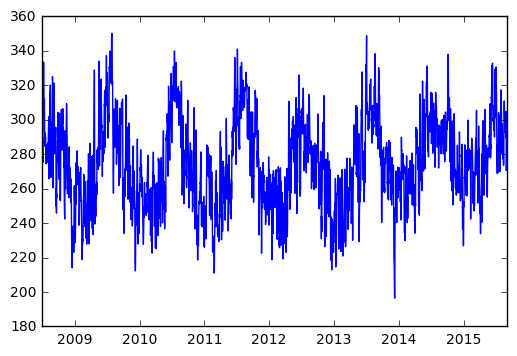

In [5]:
plt.plot(Lin[])